In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from sklearn import metrics
from tensorflow.python.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

#reindex dataframe
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
print(california_housing_dataframe)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11316     -114.3      34.2                15.0       5612.0          1283.0   
11604     -114.5      34.4                19.0       7650.0          1901.0   
10234     -114.6      33.7                17.0        720.0           174.0   
10645     -114.6      33.6                14.0       1501.0           337.0   
12134     -114.6      33.6                20.0       1454.0           326.0   
...          ...       ...                 ...          ...             ...   
5911      -124.3      40.6                52.0       2217.0           394.0   
301       -124.3      40.7                36.0       2349.0           528.0   
8087      -124.3      41.8                17.0       2677.0           531.0   
443       -124.3      41.8                19.0       2672.0           552.0   
4974      -124.3      40.5                52.0       1820.0           300.0   

       population  households  median_income  media

In [2]:
def preprocess_features(california_housing_dataframe):
    """
      Prepares input features from California housing data set.

      Args: california_housing_dataframe: A Pandas DataFrame expected to contain data
          from the California housing data set.
      Returns: A DataFrame that contains the features to be used for the model, including
        synthetic features.
    """
    selected_features = california_housing_dataframe[
       ["longitude",
        "latitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (processed_features["total_rooms"] / processed_features["population"]);
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """
        Prepares target features (i.e., labels) from California housing data set.

        Args: california_housing_dataframe: A Pandas DataFrame expected to contain data
          from the California housing data set.
        Returns: A DataFrame that contains the target feature.
    """
    selected_targets = pd.DataFrame()
    selected_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return selected_targets
    

Pick first 12000 records for training set

In [3]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,-118.5,34.6,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.2,1.6,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,-121.4,32.5,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,-118.9,33.8,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,-118.2,34.0,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,-117.8,34.4,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,-114.3,41.8,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [4]:
training_labels = preprocess_targets(california_housing_dataframe.head(12000))
training_labels.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


Validation set: 5000 samples

In [5]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,-122.2,38.1,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.5,0.9,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,-124.3,36.1,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,-122.4,37.5,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,-122.1,37.8,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,-121.9,38.4,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,-121.4,42.0,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [6]:
validation_labels = preprocess_targets(california_housing_dataframe.tail(5000))
validation_labels.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


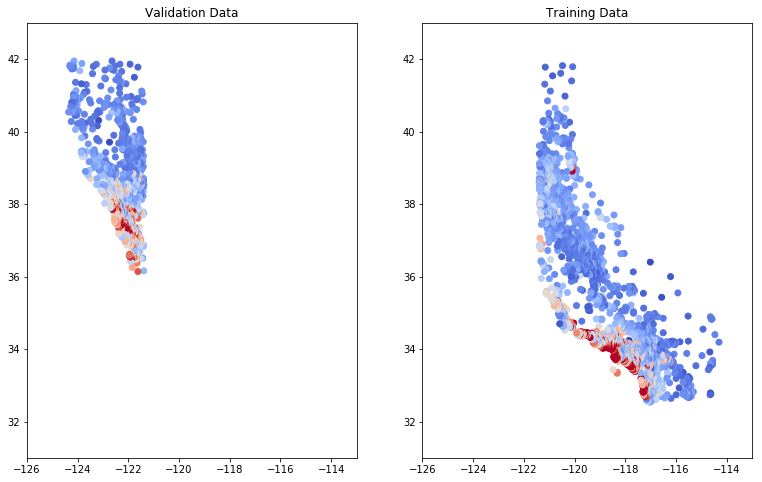

In [7]:
ax = plt.figure(figsize=(13,8))

ax = plt.subplot(1,2,1)
ax.set_title("Validation Data")
ax.set_ylim([31, 43])
ax.set_autoscaley_on(False)
ax.set_xlim([-126, -113])
ax.set_autoscalex_on(False)
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c = (validation_labels["median_house_value"] / validation_labels["median_house_value"].max()))

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")
ax.set_ylim([31,43])
ax.set_autoscaley_on(False)
ax.set_xlim([-126, -113])
ax.set_autoscalex_on(False)
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c = (training_labels["median_house_value"] / training_labels["median_house_value"].max()))
_ = plt.plot()

Train and evaluate the model

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    #Convert pandas data into a dict of np arrays
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    #Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #Shuffle the data, if specified
    if shuffle:
        ds.shuffle(10000)
    
    #Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [9]:
def construct_feature_columns(input_features):
    """
    Construct the TensorFlow Feature Columns.

    Args: input_features: The names of the numerical input features to use.
    Returns: A set of feature columns
    """
    return set([tf.feature_column.numeric_column(feature) for feature in input_features])

In [10]:
def train_model(learning_rate,
                steps,
                batch_size,
                training_examples,
                training_targets,
                validation_examples,
                validation_targets):
    """
    Trains a linear regression model of multiple features.
  
      In addition to training, this function also prints training progress information,
      as well as a plot of the training and validation loss over time.
  
    Args:
      learning_rate: A `float`, the learning rate. 
      steps: A non-zero `int`, the total number of training steps. A training step 
              consists of a forward and backward pass using a single batch.
      batch_size: A non-zero `int`, the batch size.
      training_examples: A `DataFrame` containing one or more columns from 
              `california_housing_dataframe` to use as input features for training.
      training_targets: A `DataFrame` containing exactly one column from
              `california_housing_dataframe` to use as target for training.
      validation_examples: A `DataFrame` containing one or more columns from
              `california_housing_dataframe` to use as input features for validation.
      validation_targets: A `DataFrame` containing exactly one column from
              `california_housing_dataframe` to use as target for validation.
      
    Returns: A `LinearRegressor` object trained on the training data.
    """
    periods = 10
    steps_per_period = steps / periods
    
    #Create a linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(optimizer=my_optimizer,
                                                    feature_columns=construct_feature_columns(training_examples))
    
    # 1. create input functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value"],
                                            batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the model, but do so inside a loop so that we can
    # periodically assess loss metrics
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(input_fn = training_input_fn,
                               steps=steps_per_period)
    
        # Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
    
        # Occasionally print the current loss
        print( "period %02d : %0.2f" % (period, training_root_mean_squared_error))
    
        # Add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished")
    
    # Output a graph of loss metrics over periods.
    plt.xlabel("Periods")
    plt.ylabel("RSME errors")
    plt.title("Root mean squared error vs Periods")
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training model...
RMSE (on training data):
period 00 : 179.96
period 01 : 168.54
period 02 : 175.75
period 03 : 169.52
period 04 : 168.58
period 05 : 167.69
period 06 : 167.60
period 07 : 168.76
period 08 : 166.91
period 09 : 165.91
Model training finished


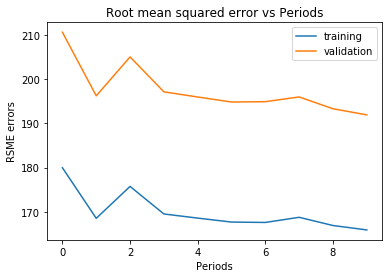

In [11]:
linear_regressor = train_model(learning_rate=0.001,
                               steps=500,
                               batch_size=10,
                               training_examples=training_examples,
                               training_targets=training_labels,
                               validation_examples=validation_examples,
                               validation_targets=validation_labels)

In [12]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
test_feature = preprocess_features(california_housing_test_data)
test_feature.describe()




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,-119.6,35.6,28.8,2599.6,530.0,1402.8,489.9,3.8,2.0
std,2.0,2.1,12.6,2155.6,415.7,1030.5,365.4,1.9,1.1
min,-124.2,32.6,1.0,6.0,2.0,5.0,2.0,0.5,0.0
25%,-121.8,33.9,18.0,1401.0,291.0,780.0,273.0,2.5,1.5
50%,-118.5,34.3,29.0,2106.0,437.0,1155.0,409.5,3.5,1.9
75%,-118.0,37.7,37.0,3129.0,636.0,1742.8,597.2,4.7,2.3
max,-114.5,41.9,52.0,30450.0,5419.0,11935.0,4930.0,15.0,33.8


In [13]:
test_labels = preprocess_targets(california_housing_test_data)
test_labels.describe()

,median_house_value
count,3000.0
mean,205.8
std,113.1
min,22.5
25%,121.2
50%,177.6
75%,264.0
max,500.0


In [14]:
predict_test_fn = lambda: my_input_fn(test_feature,
                                      test_labels["median_house_value"],
                                      shuffle=False,
                                      num_epochs=1)
test_predictions = linear_regressor.predict(predict_test_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
test_rmse = math.sqrt(metrics.mean_squared_error(test_labels, test_predictions))
print("Final RMSE for data %0.2f" % (test_rmse))

Final RMSE for data 171.03
